Modelo de prediccion BTC Close (next 30mins) usando LSTM 
====

In [19]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pytorch_model_summary import summary
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import r2_score
import mlflow

Chosse GPU instead cpu

In [20]:
# Verificar si hay una GPU disponible y establecer el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('el device es',device)

el device es cuda


Data Preprocesing
===

In [21]:
df = pd.read_csv('../../optimization_parameters_TB/BTC_1m_210601_230126.csv')
data_btc = df.iloc[:, 1:6].values   #read columns open high low close volume

In [22]:
#vamos a cambiar la temporalidad de 1 minuto a 1 hora, osea tomar 30 datos y promediarlos
data_btc_30min = np.reshape(data_btc, (29024, 30, 5))
data_btc_open = data_btc_30min[:,0,0]
data_btc_close = data_btc_30min[:,29,3]
data_btc_high = np.amax(data_btc_30min[:,:,1], axis=1)
data_btc_low = np.amin(data_btc_30min[:,:,2], axis=1)
data_btc_volume = np.sum(data_btc_30min[:,:,4], axis=1)
data_btc_30min = np.concatenate((data_btc_open[:,None], data_btc_high[:,None], data_btc_low[:,None], data_btc_close[:,None], data_btc_volume[:,None]), axis=1)

Data Normalization

In [23]:
scaler = MinMaxScaler()
scaled_data_btc = scaler.fit_transform(data_btc_30min)

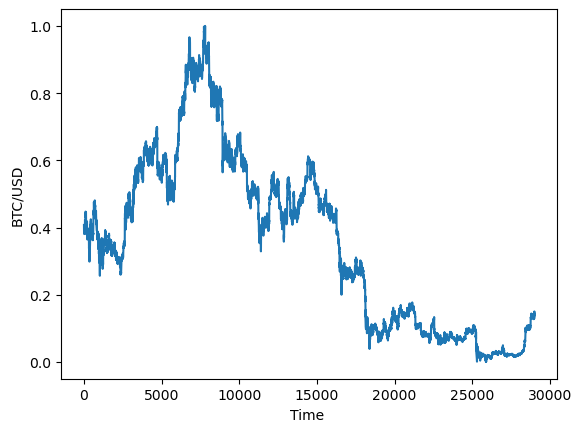

In [24]:
# Plot
plt.plot(np.arange(0,len(scaled_data_btc)),scaled_data_btc[:,0])
plt.ylabel('BTC/USD')
plt.xlabel('Time ')
plt.show()

Create sequences

In [25]:
def create_sequences(data, sequence_length):
    sequences = []
    columna_close=3
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length:i+sequence_length+1]
        sequences.append((seq, label))
    return sequences

In [26]:
sequence_length = 25  # Longitud de la secuencia de entrada
# Create sequences and corresponding labels for training set
sequences = create_sequences(scaled_data_btc, sequence_length)

Training and testing Tensors

In [27]:
train_size = int(0.8 * len(sequences))
train_data = sequences[:train_size]
test_data = sequences[train_size:]

# Crear DataLoader para cargar los datos
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

LSTM Model

In [28]:
# Definir la arquitectura de la red LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,dtype=torch.float).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,dtype=torch.float).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Tomar la última salida de la secuencia
        return out

Training function

In [29]:
def train_model(model,train_loader, num_epochs, learning_rate):
    # Función de pérdida y optimizador
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_list = []

    # Entrenamiento del modelo
    for epoch in range(num_epochs):
        for seq, label in train_loader:
            seq = seq.float()
            label = label.squeeze(1)
            # Mover las secuencias y etiquetas a la GPU
            seq, label = seq.to(device), label.to(device)
            outputs = model(seq)
            #print('outputs',outputs.shape)
            optimizer.zero_grad()
            loss = criterion(outputs, label.float())
            loss.backward()
            optimizer.step()
            
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.11f}')
        loss_list.append(loss.item())

    return loss_list

Trainig the model

In [30]:
# Hiperparámetros
sequence_length = 25  # Longitud de la secuencia de entrada
input_size = 5       # Tamaño de entrada (univariado)
hidden_size = 64     # Tamaño de la capa oculta LSTM
num_layers = 2       # Número de capas LSTM
output_size = 5      # Tamaño de salida (univariado)
learning_rate = 0.0002
num_epochs = 100
#seed 
torch.manual_seed(0)
model = LSTM(input_size, hidden_size, num_layers, output_size)
model.to(device)
loss_list=train_model(model,train_loader, num_epochs, learning_rate)

Epoch [10/100], Loss: 0.00022828420
Epoch [20/100], Loss: 0.00020867595
Epoch [30/100], Loss: 0.00016931041
Epoch [40/100], Loss: 0.00017679829
Epoch [50/100], Loss: 0.00016319002
Epoch [60/100], Loss: 0.00016012588
Epoch [70/100], Loss: 0.00016431279
Epoch [80/100], Loss: 0.00016104791
Epoch [90/100], Loss: 0.00015916160
Epoch [100/100], Loss: 0.00015343034


Loss plot

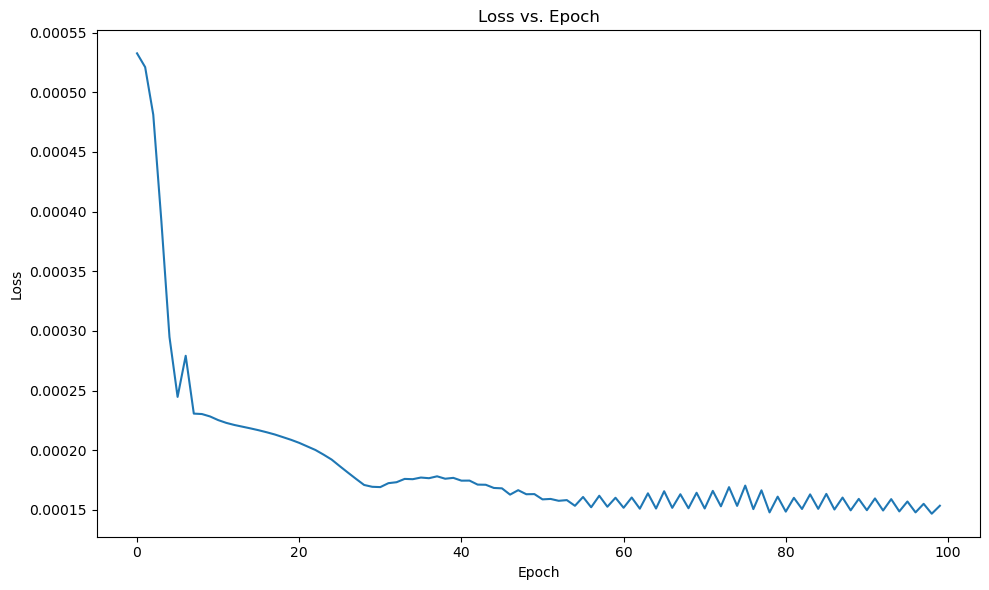

In [126]:
def loss_plot(loss_list):
    plt.figure(figsize=(10, 6)) 
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')

    plt.tight_layout()
    plt.savefig('plots_lstm/loss_plot.png',dpi=300)
    plt.show()

loss_plot(loss_list)

Predicting Function

In [32]:
def predict(model,test_data):
    # Hacer predicciones
    model.eval()
    model.cpu()

    with torch.no_grad():
        test_seq = torch.FloatTensor(test_data[0][0]).unsqueeze(dim=0)
        test_predictions = []
        for i in range(len(test_data)):
            prediction = model(test_seq)
            test_predictions.append(prediction)
            test_seq = torch.FloatTensor(test_data[i][0]).unsqueeze(dim=0)
    return torch.stack(test_predictions).cpu().detach().numpy().reshape(-1,5)

In [33]:
test_predictions= predict(model,test_data)

plot predictions using testing

In [121]:
def plot_predictions(test_data,test_predictions):
    #reverse scaling
    test_predictions=scaler.inverse_transform(test_predictions)
    #print(test_data.shape)
    test_data=scaler.inverse_transform(np.array(test_data))
    
    plt.figure(figsize=(10, 6)) 

    #plot datos btc and test_predictions
    plt.plot(np.arange(len(train_data)+sequence_length,len(scaled_data_btc)), test_data[len(train_data)+sequence_length:len(scaled_data_btc),3],label='Original Values')
    plt.plot(np.arange(len(train_data)+sequence_length,len(scaled_data_btc)), test_predictions[:,3],label='Predicted Values')
    #if you can see with more detail the plot, uncomment the next line
    #plt.axis(xmin=25000, xmax=25030, ymin=0.085, ymax=0.1)

    plt.ylabel('BTC/USD')
    plt.xlabel('Time (30 min)')
    plt.title('BTC/USD Training Phase')
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    
    plt.tight_layout()
    plt.savefig('plots_lstm/prediction_plot.png',dpi=300)
    plt.show()

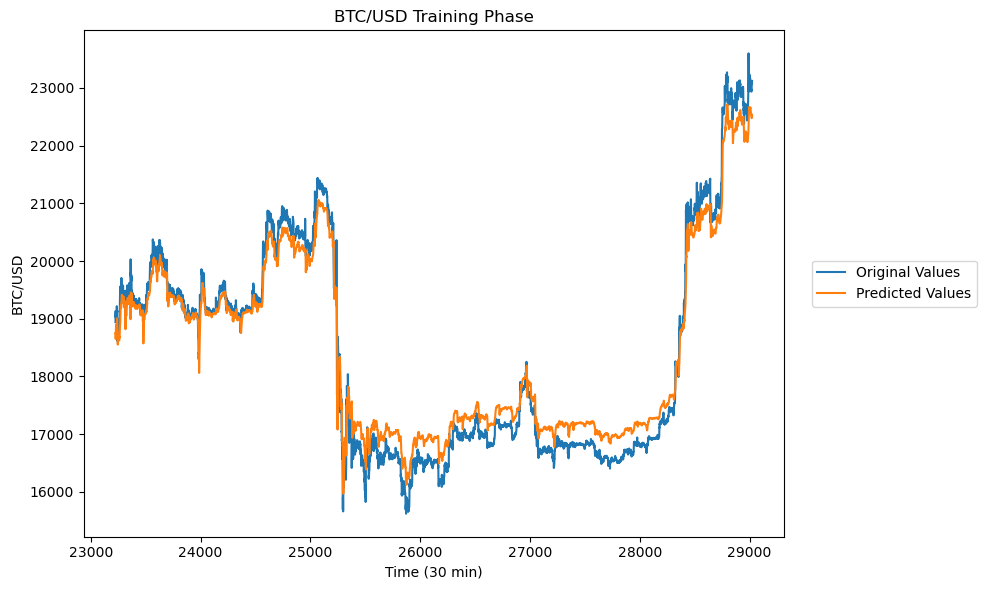

In [122]:
plot_predictions(scaled_data_btc,test_predictions)

RMS and r2

In [15]:
def rmse(predictions, targets):
    RMS=np.sqrt(np.mean(np.power((targets[len(train_data)+sequence_length:len(train_data)+sequence_length+len(predictions),3]-predictions[:,3]),2)))
    print('RMS',RMS)
    return RMS

def rsquare(predictions, targets):
    r2 = r2_score(targets[len(train_data)+sequence_length:len(train_data)+sequence_length+len(predictions),3], predictions[:,3])
    print('r2',r2)
    return r2

In [250]:
RMS=rmse(test_predictions, scaled_data_btc)
r2=rsquare(test_predictions, scaled_data_btc)

RMS 0.0061954919714975985
r2 0.9695037159010501


Guardamos los pesos

In [16]:
def save_model(model,sequence_length,input_size,hidden_size,num_layers,output_size,learning_rate,num_epochs,name):
    #guardar el modelo
    torch.save(model.state_dict(), 'weights_and_params/'+ name + '.pth')
    #guardar parametros de el modelo e hyperparametros en un csv
    data = {'sequence_length':sequence_length,'input_size':input_size,'hidden_size':hidden_size,'num_layers':num_layers,'output_size':output_size,
    'learning_rate':learning_rate,'num_epochs':num_epochs,'batch_size':64,'numero de datos':len(sequences)}
    df = pd.DataFrame(data=data,index=[0])
    df.to_csv('weights_and_params/'+ name+ '_parameters.csv',index=False)

In [245]:
save_model(model,sequence_length,input_size,hidden_size,num_layers,output_size,learning_rate,num_epochs,'lstm_model_30min_1')

In [157]:
#cargar los pesos del modelo entrenado
input_size=5
hidden_size=64
num_layers=2
output_size=5

ModelPredict = LSTM(input_size, hidden_size, num_layers, output_size)
ModelPredict.load_state_dict(torch.load('lstm_model_30min_1.pth'))
ModelPredict.eval()

LSTM(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

Hacer prediccion sobre el testing y calcular RMS

In [135]:
def closeup_plot(test_data,test_predictions):
    #reverse scaling
    test_predictions=scaler.inverse_transform(test_predictions)
    test_data=scaler.inverse_transform(np.array(test_data))


    #plot datos btc and test_predictions
    plt.figure(figsize=(10, 6)) 
    plt.plot(np.arange(len(train_data)+sequence_length,len(scaled_data_btc)), test_data[len(train_data)+sequence_length:len(scaled_data_btc),3],label='Original Values')
    plt.plot(np.arange(len(train_data)+sequence_length,len(scaled_data_btc)), test_predictions[:,3],label='Predicted Values')
    #if you can see with more detail the plot, uncomment the next line
    initial_prediction=len(train_data)+sequence_length
    window=70
    max_y_real=max(test_data[initial_prediction:initial_prediction+window,3])
    min_y_real=min(test_data[initial_prediction:initial_prediction+window,3])
    print(min_y_real)
    max_y_pred=max(test_predictions[0:50,3])
    min_y_pred=min(test_predictions[0:50,3])
    max_y_plot=max(max_y_real,max_y_pred)
    min_y_plot=min(min_y_real,min_y_pred)

    plt.axis(xmin=initial_prediction, xmax=initial_prediction+window, ymin=min_y_plot, ymax=max_y_plot)

    plt.ylabel('BTC/USD')
    plt.xlabel('Time (30 min)')
    plt.title('BTC/USD Real Values vs Predicted Values (Close Up window 70)')
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

    plt.tight_layout()
    plt.subplots_adjust(right=0.8)

    plt.savefig('plots_lstm/closeup_prediction_plot.png',dpi=300)
    plt.show()

18615.0


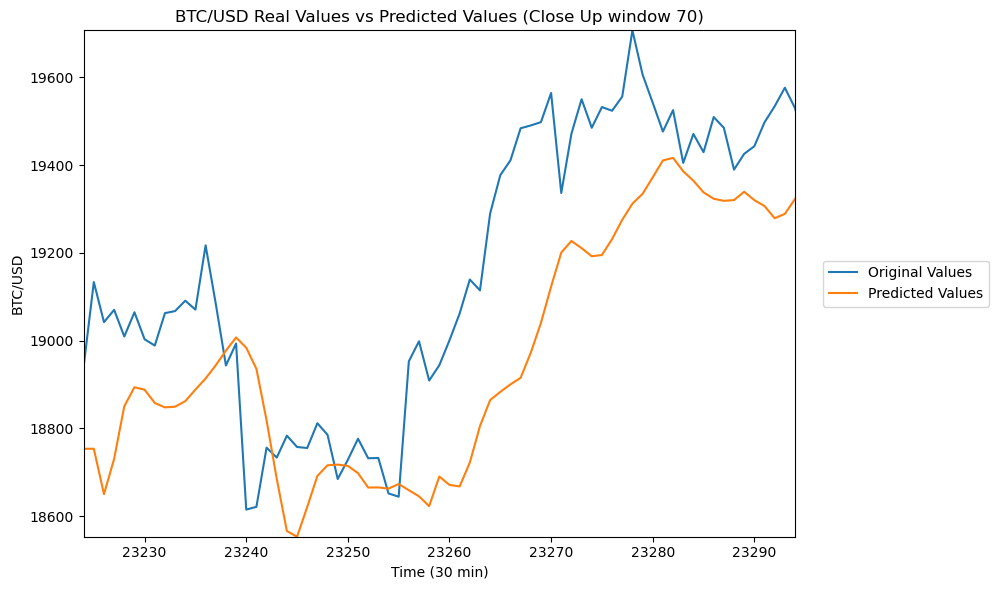

In [136]:
closeup_plot(scaled_data_btc,test_predictions)

In [137]:
def diff_plot(predictions,targets):
    #reverse scaling
    predictions=scaler.inverse_transform(predictions)
    targets=scaler.inverse_transform(targets)

    rmse_list=[]
    
    for prediction in range(len(predictions)):
        dif=targets[len(train_data)+sequence_length+prediction,3]-predictions[prediction,3]
        rmse_list.append(dif)
    
    promedio=sum(rmse_list)/len(rmse_list)
    print('promedio',promedio)

    plt.figure(figsize=(10, 6)) 

    plt.plot(np.arange(len(train_data)+sequence_length,len(scaled_data_btc)), rmse_list,label='RMSE')

    #poner el promedio en la grafica y su valor encima de la recta 1 decimal
    plt.axhline(y=promedio, color='r', linestyle='-',label='Average='+str(round(promedio,1)))
    #poner labels 
    plt.ylabel('BTC/USD')
    plt.xlabel('Time (30 min)')
    plt.title('diff between Real Values vs Predicted Values BTC/USD')
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.8)
    plt.savefig('plots_lstm/diff_prediction_plot.png',dpi=300)
    plt.show()
    

promedio -70.0307073006463


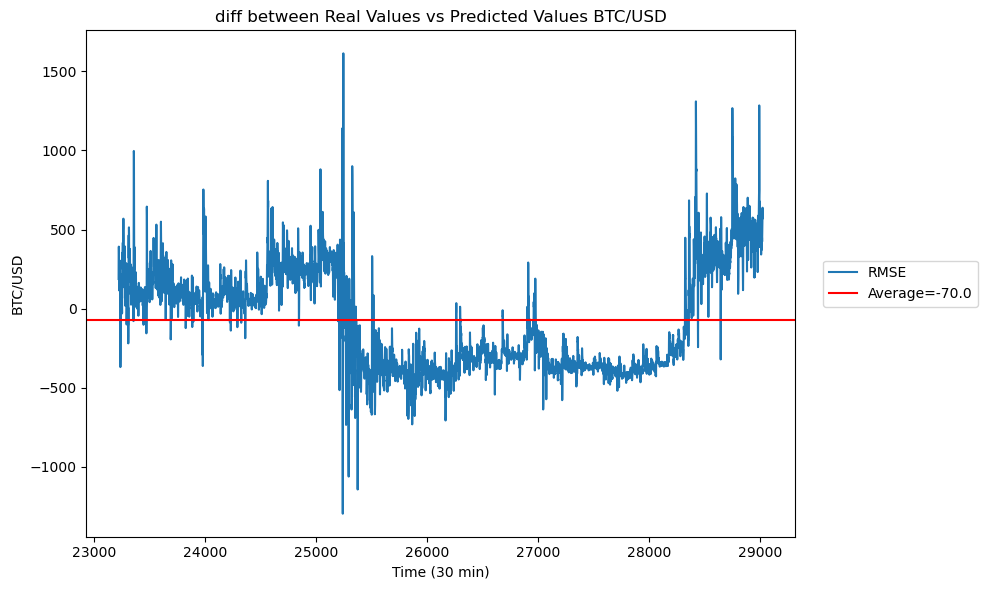

In [138]:
diff_plot(test_predictions,scaled_data_btc)

MLFLOW Runings
===

In [144]:
# Hiperparámetros
sequence_length = 25  # Longitud de la secuencia de entrada
input_size = 5       # Tamaño de entrada (univariado)
hidden_size = 64     # Tamaño de la capa oculta LSTM
num_layers = 2       # Número de capas LSTM
output_size = 5      # Tamaño de salida (univariado)
learning_rate = 0.00008
num_epochs = 500

params = [sequence_length,input_size,hidden_size,num_layers,output_size,learning_rate,num_epochs]

In [147]:
def complete_run(params,train_loader,test_data,name):
    #------------------------------------MLFLOW------------------------------------
    #crear experimento en mlflow sino existe
    # Crear el experimento
    experiment_name = "LSTM"
    # Verificar si el experimento ya existe
    experiment = mlflow.get_experiment_by_name(experiment_name)

    if experiment is None:
        # Si no existe, crear el experimento
        experiment_id = mlflow.create_experiment(experiment_name)
    else:
        # Si ya existe, obtener el experimento
        experiment_id = experiment.experiment_id
        
    run_name=name

    with mlflow.start_run(experiment_id=experiment_id,run_name=run_name) as run:
        # Hiperparámetros
        sequence_length = params[0];input_size = params[1];hidden_size = params[2];num_layers = params[3];output_size = params[4];learning_rate = params[5];num_epochs = params[6]
        mlflow.log_params({"sequence_length": sequence_length, "input_size": input_size, "hidden_size": hidden_size, "num_layers": num_layers, "output_size": output_size,
         "learning_rate": learning_rate, "num_epochs": num_epochs})

        torch.manual_seed(0)
        model = LSTM(input_size, hidden_size, num_layers, output_size)
        model.to(device)
        loss_list=train_model(model,train_loader, num_epochs, learning_rate)
        loss_plot(loss_list)
        test_predictions= predict(model,test_data)
        plot_predictions(scaled_data_btc,test_predictions)
        closeup_plot(scaled_data_btc,test_predictions)
        diff_plot(test_predictions,scaled_data_btc)

        #metrics
        RMS=rmse(test_predictions, scaled_data_btc)
        r2=rsquare(test_predictions, scaled_data_btc)
        mlflow.log_metrics({"RMS": RMS, "r2": r2})

        #save model
        save_model(model,sequence_length,input_size,hidden_size,num_layers,output_size,learning_rate,num_epochs,name)

        #save weights in mlflow
        mlflow.log_artifact('weights_and_params/' + name + '.pth')
        mlflow.log_artifact('weights_and_params/' + name + '_parameters.csv')

        #save plots in mlflow
        mlflow.log_artifact('plots_lstm\loss_plot.png')
        mlflow.log_artifact('plots_lstm\closeup_prediction_plot.png')
        mlflow.log_artifact('plots_lstm\prediction_plot.png')
        mlflow.log_artifact('plots_lstm\diff_prediction_plot.png')


Epoch [10/500], Loss: 0.00024342207
Epoch [20/500], Loss: 0.00023842324
Epoch [30/500], Loss: 0.00022796594
Epoch [40/500], Loss: 0.00021762575
Epoch [50/500], Loss: 0.00018835833
Epoch [60/500], Loss: 0.00015708643
Epoch [70/500], Loss: 0.00015073840
Epoch [80/500], Loss: 0.00014958654
Epoch [90/500], Loss: 0.00014959139
Epoch [100/500], Loss: 0.00014758961
Epoch [110/500], Loss: 0.00014369668
Epoch [120/500], Loss: 0.00014025648
Epoch [130/500], Loss: 0.00013751618
Epoch [140/500], Loss: 0.00013472166
Epoch [150/500], Loss: 0.00013239236
Epoch [160/500], Loss: 0.00013001455
Epoch [170/500], Loss: 0.00012597331
Epoch [180/500], Loss: 0.00012272689
Epoch [190/500], Loss: 0.00011994036
Epoch [200/500], Loss: 0.00011786780
Epoch [210/500], Loss: 0.00011526408
Epoch [220/500], Loss: 0.00011307967
Epoch [230/500], Loss: 0.00011179405
Epoch [240/500], Loss: 0.00011071856
Epoch [250/500], Loss: 0.00010978551
Epoch [260/500], Loss: 0.00010887582
Epoch [270/500], Loss: 0.00010800841
Epoch [280

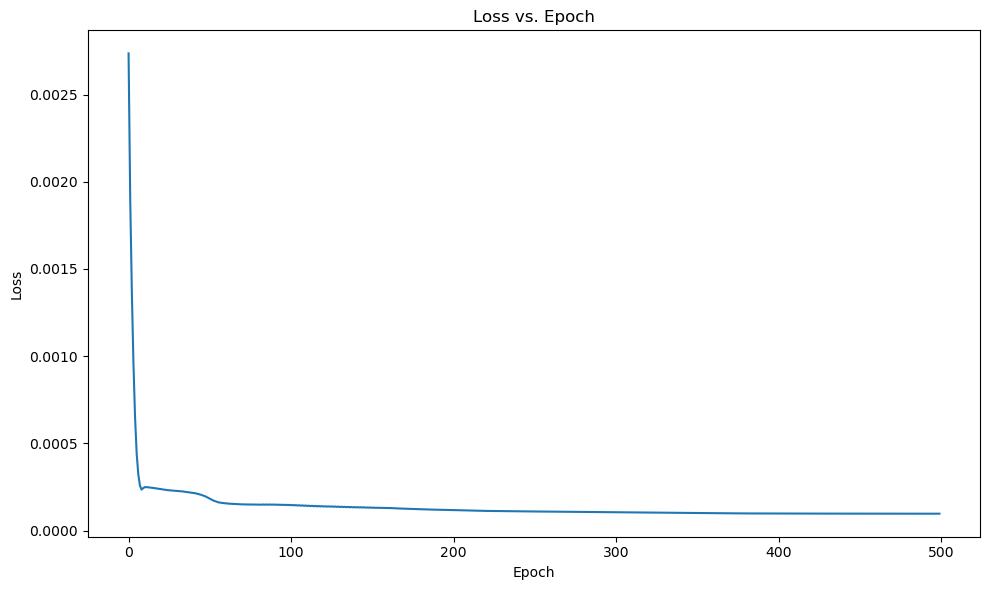

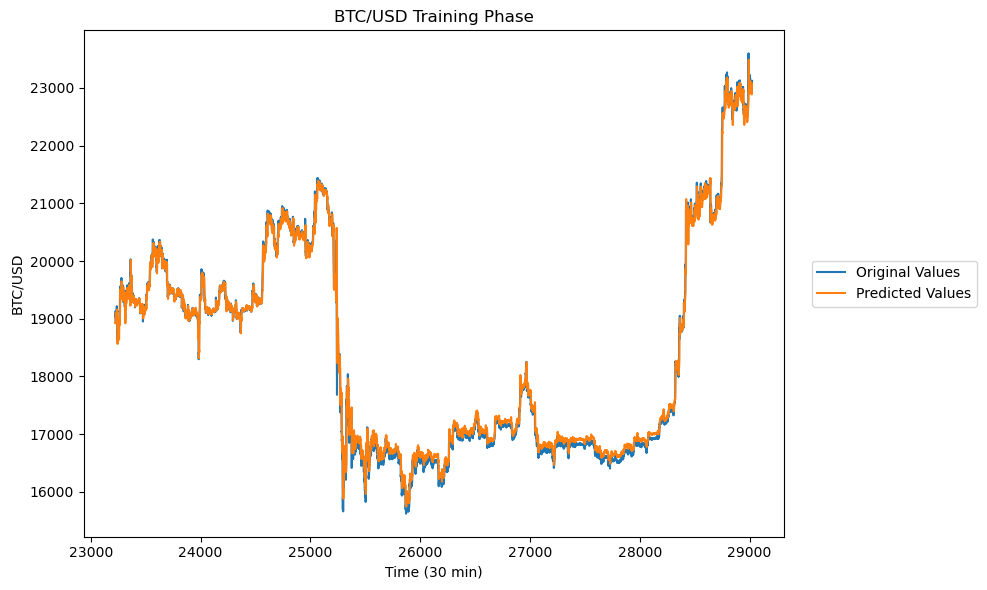

18615.0


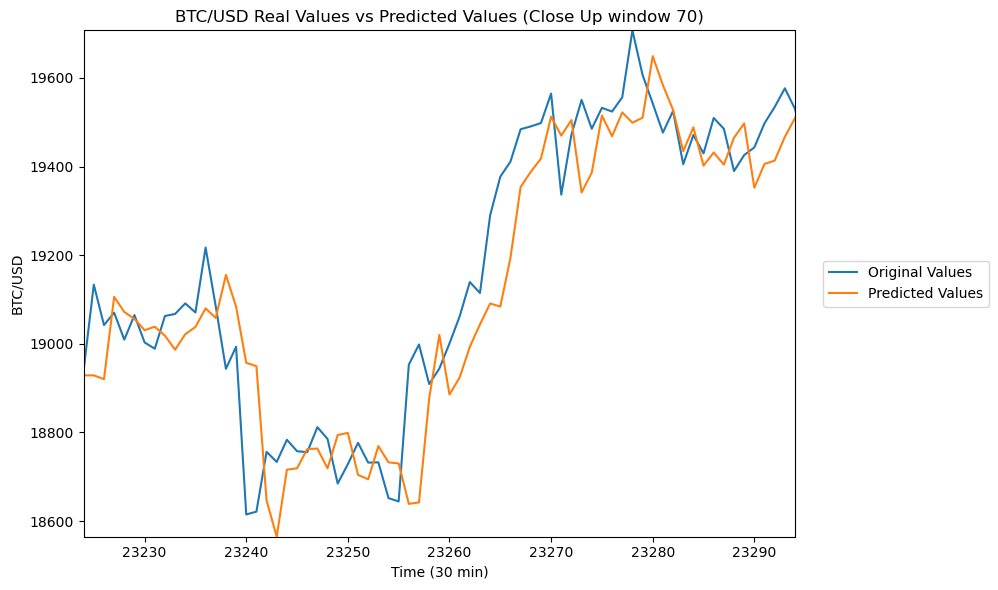

promedio -33.73850010102378


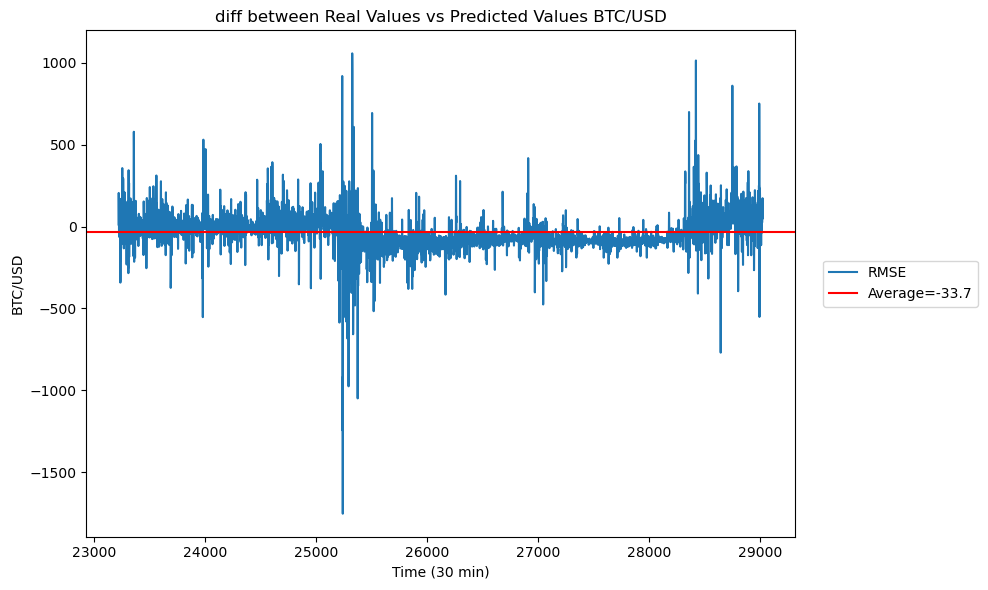

RMS 0.002265055224561911
r2 0.9959238240912542


In [148]:
complete_run(params,train_loader,test_data,'lstm_model_30min_1')

Epoch [10/500], Loss: 0.00024594119
Epoch [20/500], Loss: 0.00054893835
Epoch [30/500], Loss: 0.00069943129
Epoch [40/500], Loss: 0.00067102083
Epoch [50/500], Loss: 0.00063227763
Epoch [60/500], Loss: 0.00060822273
Epoch [70/500], Loss: 0.00059152435
Epoch [80/500], Loss: 0.00057543349
Epoch [90/500], Loss: 0.00055515755
Epoch [100/500], Loss: 0.00053192204
Epoch [110/500], Loss: 0.00050618447
Epoch [120/500], Loss: 0.00047854474
Epoch [130/500], Loss: 0.00045402025
Epoch [140/500], Loss: 0.00043008965
Epoch [150/500], Loss: 0.00040494394
Epoch [160/500], Loss: 0.00037919855
Epoch [170/500], Loss: 0.00034928721
Epoch [180/500], Loss: 0.00031794206
Epoch [190/500], Loss: 0.00026400757
Epoch [200/500], Loss: 0.00021927757
Epoch [210/500], Loss: 0.00018484425
Epoch [220/500], Loss: 0.00014874472
Epoch [230/500], Loss: 0.00012759464
Epoch [240/500], Loss: 0.00011159120
Epoch [250/500], Loss: 0.00010378227
Epoch [260/500], Loss: 0.00010062887
Epoch [270/500], Loss: 0.00009809113
Epoch [280

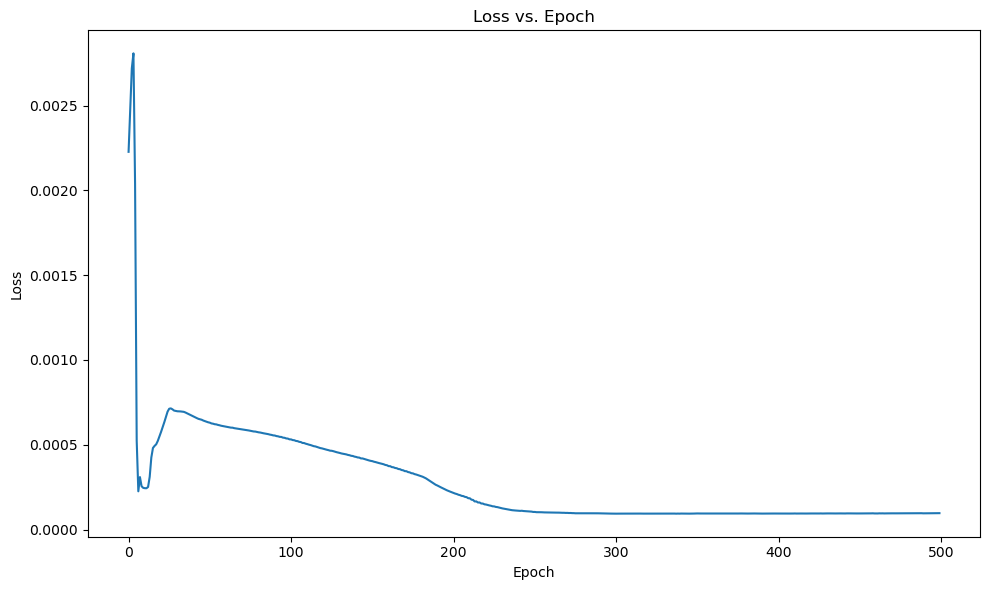

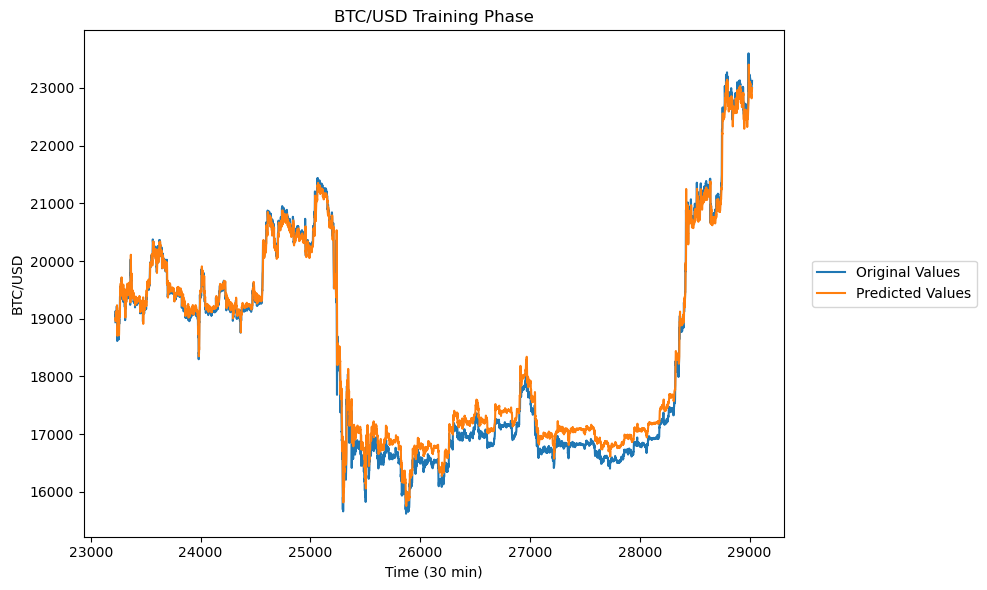

18615.0


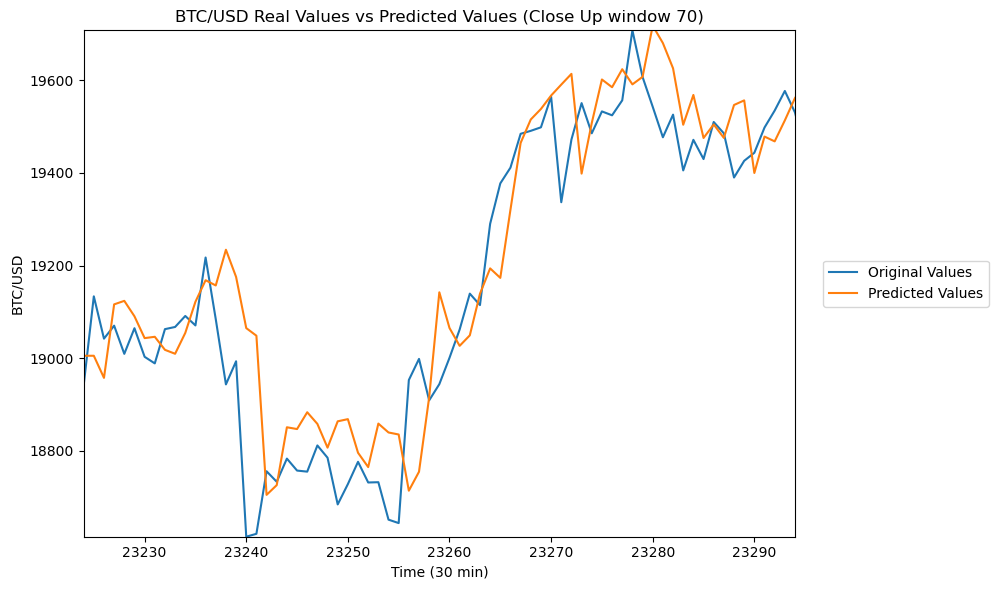

promedio -121.08547124191777


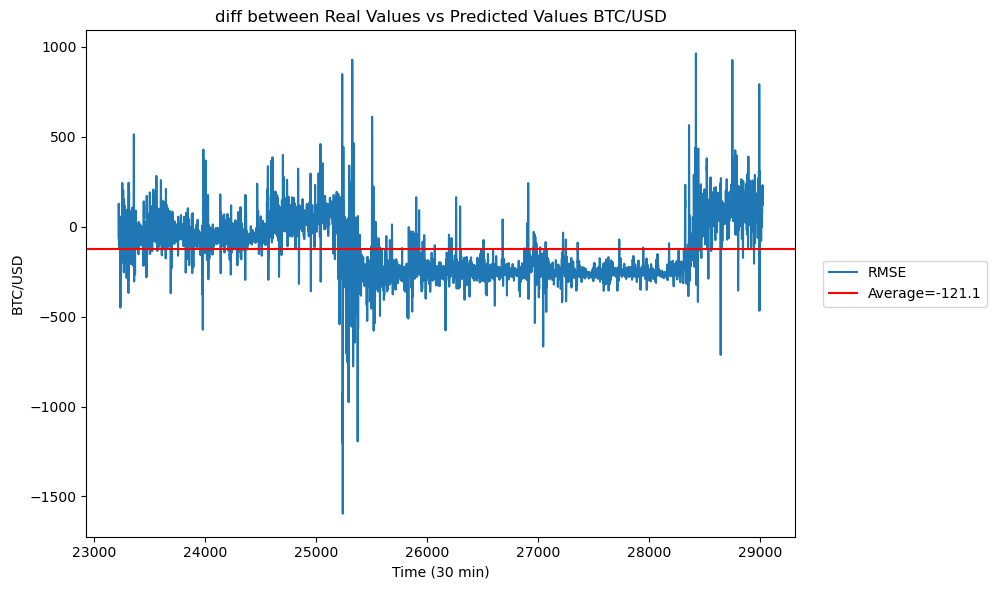

RMS 0.0038760487741485126
r2 0.9880635881693862


In [149]:
# Hiperparámetros
sequence_length = 25  # Longitud de la secuencia de entrada
input_size = 5       # Tamaño de entrada (univariado)
hidden_size = 64     # Tamaño de la capa oculta LSTM
num_layers = 5       # Número de capas LSTM
output_size = 5      # Tamaño de salida (univariado)
learning_rate = 0.00008
num_epochs = 500
params = [sequence_length,input_size,hidden_size,num_layers,output_size,learning_rate,num_epochs]
complete_run(params,train_loader,test_data,'lstm_model_30min_2')



Epoch [10/500], Loss: 0.00078968203
Epoch [20/500], Loss: 0.00057548872
Epoch [30/500], Loss: 0.00070974708
Epoch [40/500], Loss: 0.00063188700
Epoch [50/500], Loss: 0.00059464254
Epoch [60/500], Loss: 0.00059265789
Epoch [70/500], Loss: 0.00057756837
Epoch [80/500], Loss: 0.00055344967
Epoch [90/500], Loss: 0.00051785237
Epoch [100/500], Loss: 0.00049559894
Epoch [110/500], Loss: 0.00047632380
Epoch [120/500], Loss: 0.00044828173
Epoch [130/500], Loss: 0.00037344571
Epoch [140/500], Loss: 0.00026354496
Epoch [150/500], Loss: 0.00022692252
Epoch [160/500], Loss: 0.00016202044
Epoch [170/500], Loss: 0.00011473295
Epoch [180/500], Loss: 0.00011480571
Epoch [190/500], Loss: 0.00009982706
Epoch [200/500], Loss: 0.00009881004
Epoch [210/500], Loss: 0.00009824939
Epoch [220/500], Loss: 0.00009930704
Epoch [230/500], Loss: 0.00010386383
Epoch [240/500], Loss: 0.00010090267
Epoch [250/500], Loss: 0.00009801352
Epoch [260/500], Loss: 0.00009731056
Epoch [270/500], Loss: 0.00009799327
Epoch [280

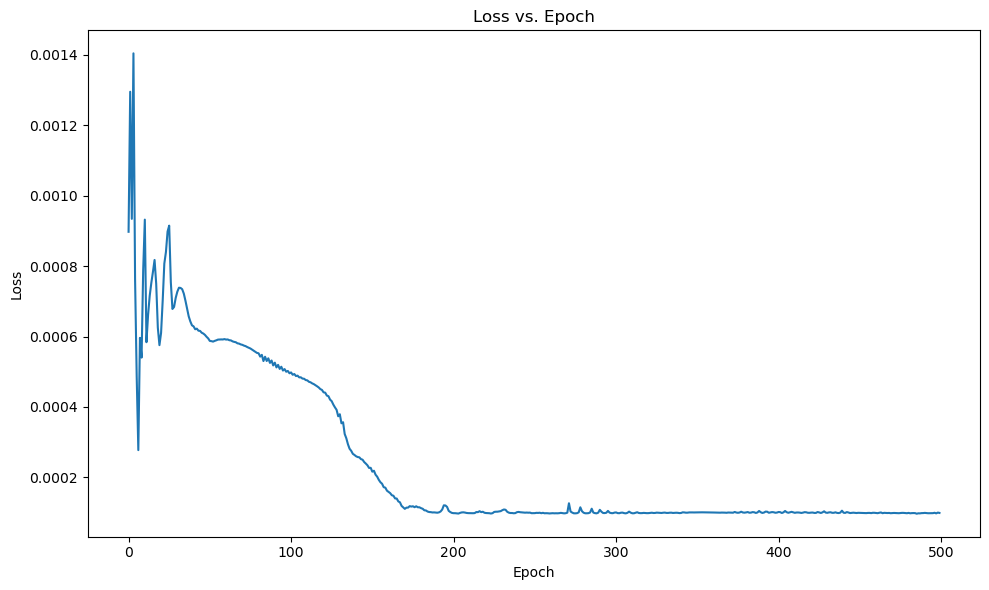

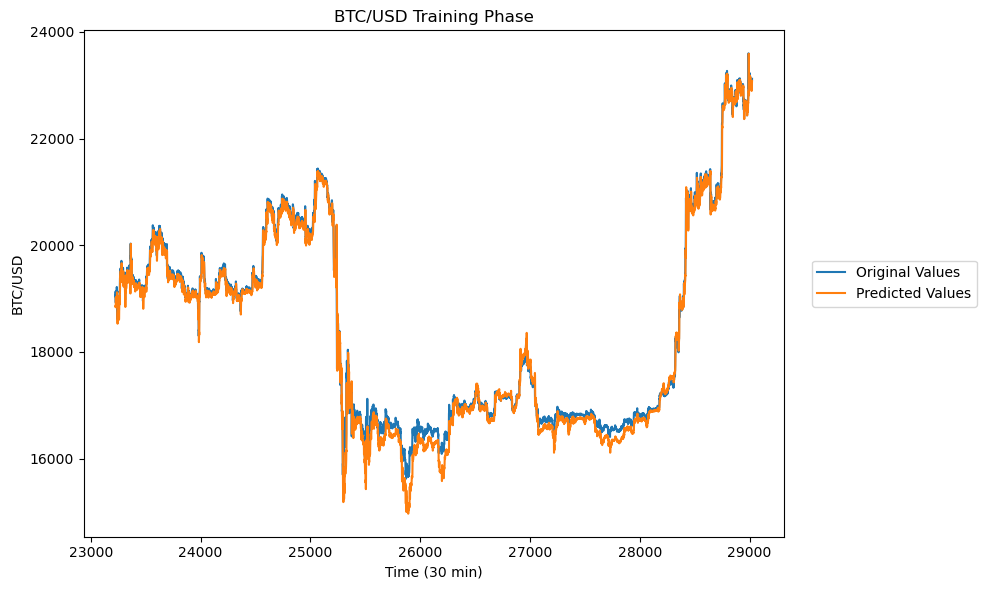

18615.0


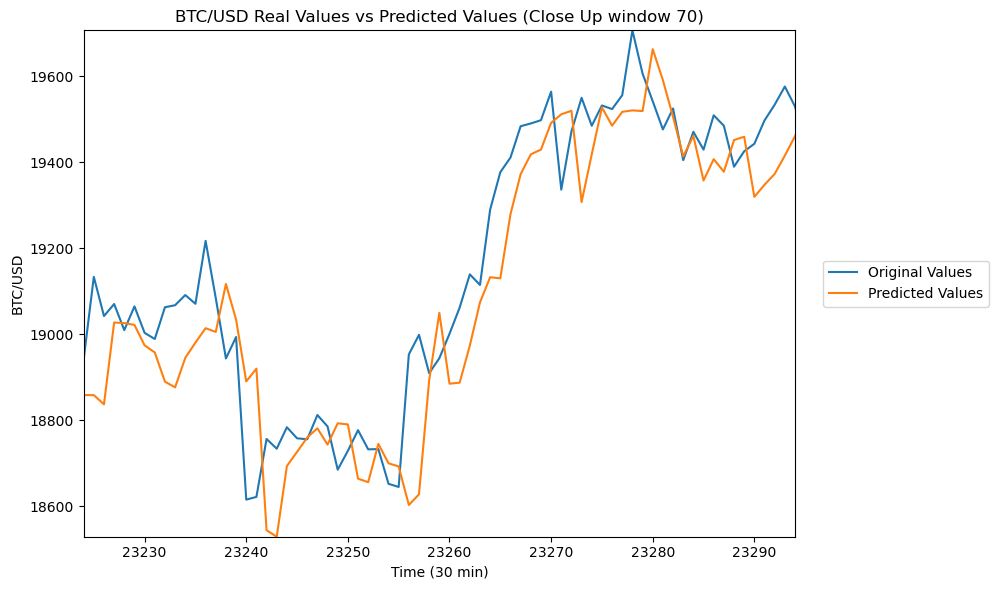

promedio 98.79180162311437


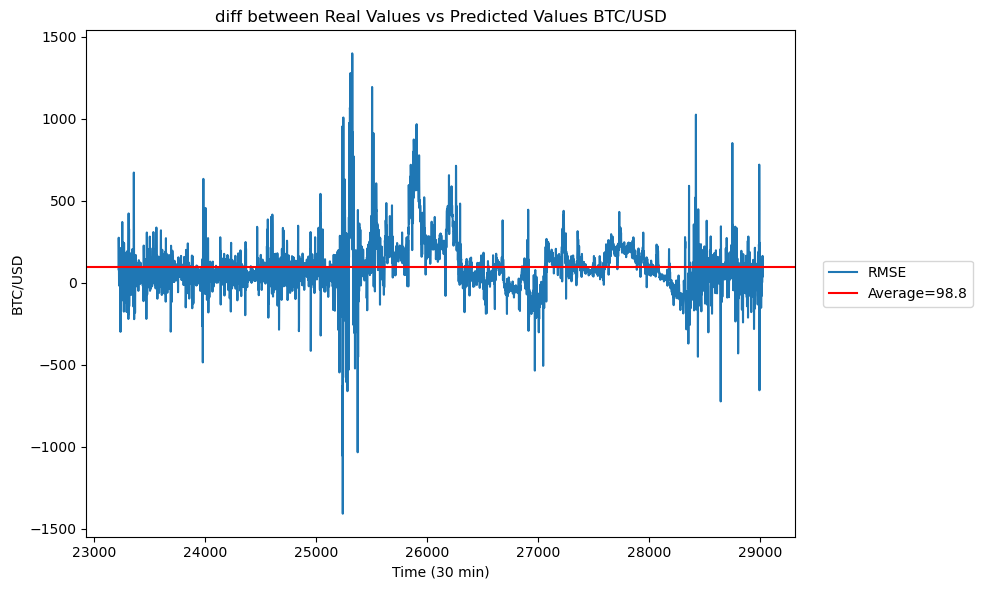

RMS 0.003584145113395805
r2 0.9897937430571947


In [150]:
# Hiperparámetros
sequence_length = 25  # Longitud de la secuencia de entrada
input_size = 5       # Tamaño de entrada (univariado)
hidden_size = 150     # Tamaño de la capa oculta LSTM
num_layers = 5       # Número de capas LSTM
output_size = 5      # Tamaño de salida (univariado)
learning_rate = 0.00008
num_epochs = 500
params = [sequence_length,input_size,hidden_size,num_layers,output_size,learning_rate,num_epochs]
complete_run(params,train_loader,test_data,'lstm_model_30min_3')

Epoch [10/500], Loss: 0.00342474435
Epoch [20/500], Loss: 0.01880282350
Epoch [30/500], Loss: 0.03729302809
Epoch [40/500], Loss: 0.04447290674
Epoch [50/500], Loss: 0.05198016390
Epoch [60/500], Loss: 0.05468119308
Epoch [70/500], Loss: 0.00021459688
Epoch [80/500], Loss: 0.03092685714
Epoch [90/500], Loss: 0.06043329462
Epoch [100/500], Loss: 0.00909360778
Epoch [110/500], Loss: 0.06432087719
Epoch [120/500], Loss: 0.06899262220
Epoch [130/500], Loss: 0.00040774854
Epoch [140/500], Loss: 0.00025616403
Epoch [150/500], Loss: 0.00026365489
Epoch [160/500], Loss: 0.00027903286
Epoch [170/500], Loss: 0.00025709323
Epoch [180/500], Loss: 0.00026700253
Epoch [190/500], Loss: 0.00027598577
Epoch [200/500], Loss: 0.00027952212
Epoch [210/500], Loss: 0.00024753471
Epoch [220/500], Loss: 0.00033627503
Epoch [230/500], Loss: 0.00027064644
Epoch [240/500], Loss: 0.00029365809
Epoch [250/500], Loss: 0.00035471295
Epoch [260/500], Loss: 0.00034458819
Epoch [270/500], Loss: 0.00035347758
Epoch [280

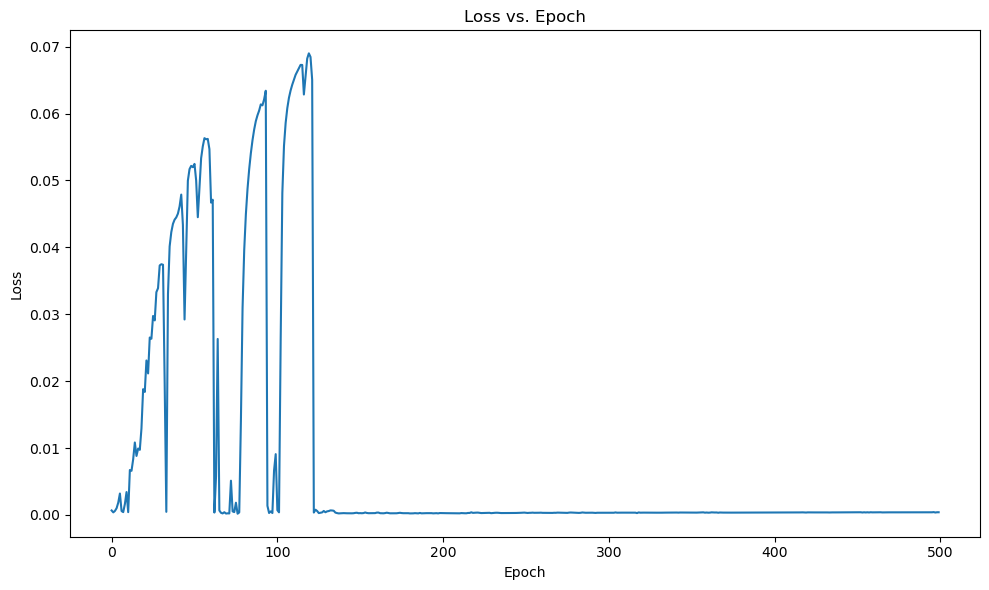

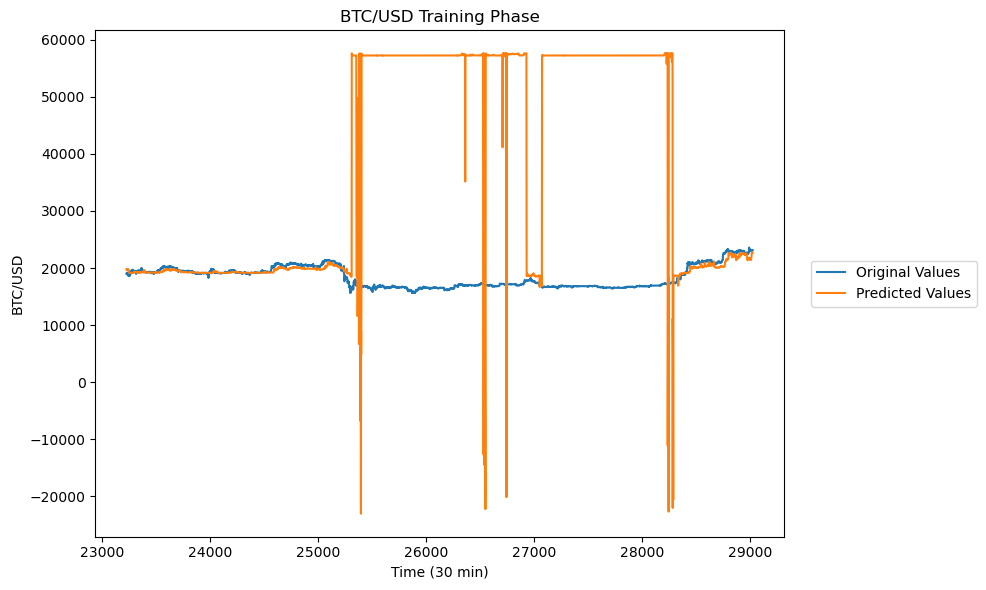

18615.0


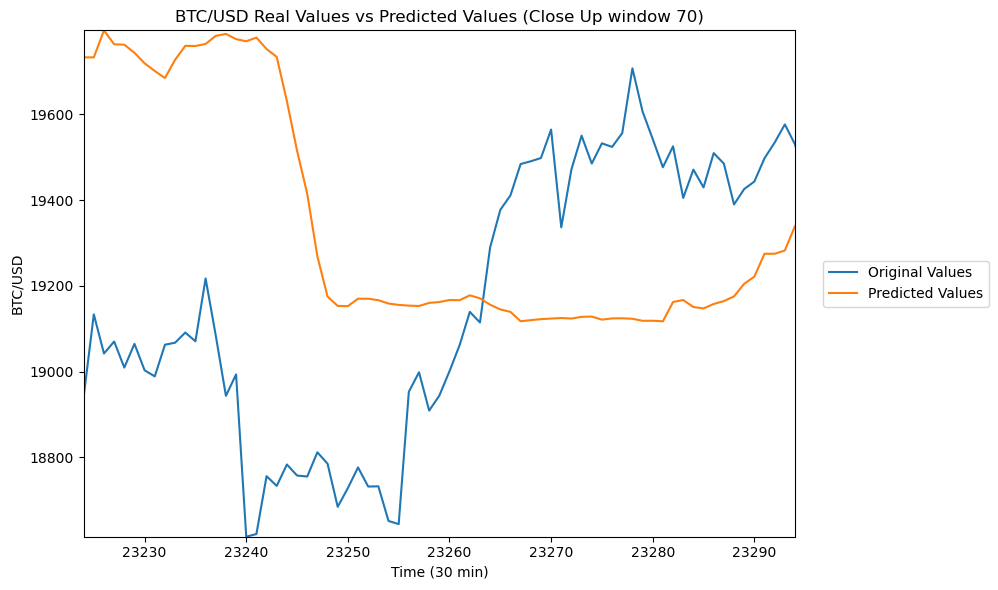

promedio -19064.800108430012


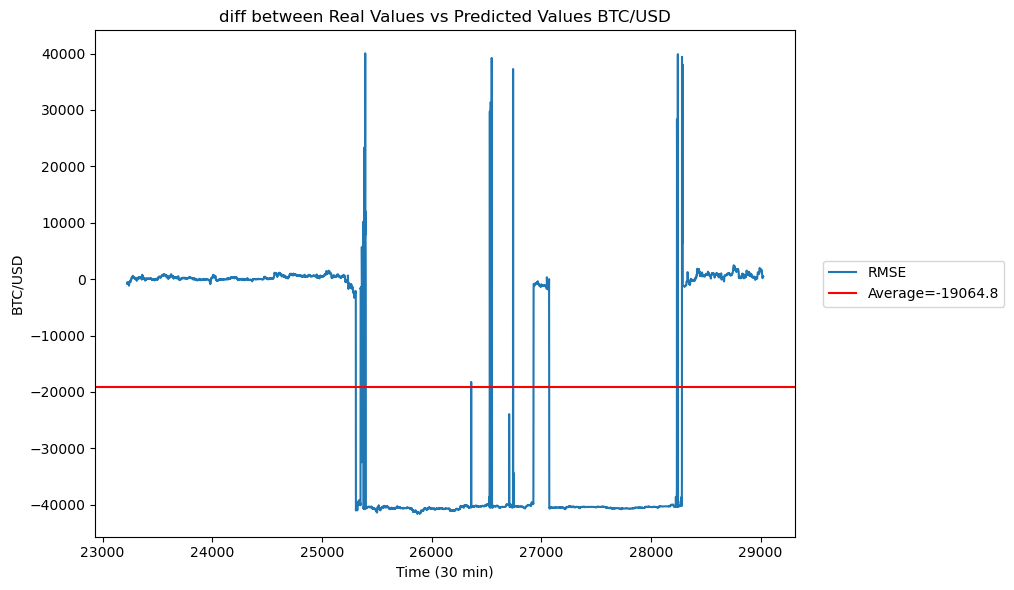

RMS 0.5275992521817663
r2 -220.15851765425975


In [151]:
# Hiperparámetros
sequence_length = 25  # Longitud de la secuencia de entrada
input_size = 5       # Tamaño de entrada (univariado)
hidden_size = 150     # Tamaño de la capa oculta LSTM
num_layers = 10       # Número de capas LSTM
output_size = 5      # Tamaño de salida (univariado)
learning_rate = 0.00008
num_epochs = 500
params = [sequence_length,input_size,hidden_size,num_layers,output_size,learning_rate,num_epochs]
complete_run(params,train_loader,test_data,'lstm_model_30min_4')

Epoch [10/5000], Loss: 0.00502834097
Epoch [20/5000], Loss: 0.00065770728
Epoch [30/5000], Loss: 0.00038247852
Epoch [40/5000], Loss: 0.00024059437
Epoch [50/5000], Loss: 0.00038353127
Epoch [60/5000], Loss: 0.00032264905
Epoch [70/5000], Loss: 0.00029134497
Epoch [80/5000], Loss: 0.00033919764
Epoch [90/5000], Loss: 0.00045095000
Epoch [100/5000], Loss: 0.00050781341
Epoch [110/5000], Loss: 0.00053604529
Epoch [120/5000], Loss: 0.00055059080
Epoch [130/5000], Loss: 0.00055763853
Epoch [140/5000], Loss: 0.00055994297
Epoch [150/5000], Loss: 0.00055802090
Epoch [160/5000], Loss: 0.00055327063
Epoch [170/5000], Loss: 0.00054676016
Epoch [180/5000], Loss: 0.00054055243
Epoch [190/5000], Loss: 0.00053388963
Epoch [200/5000], Loss: 0.00052954070
Epoch [210/5000], Loss: 0.00052499445
Epoch [220/5000], Loss: 0.00052198605
Epoch [230/5000], Loss: 0.00051938876
Epoch [240/5000], Loss: 0.00051732210
Epoch [250/5000], Loss: 0.00051474629
Epoch [260/5000], Loss: 0.00051116338
Epoch [270/5000], Los

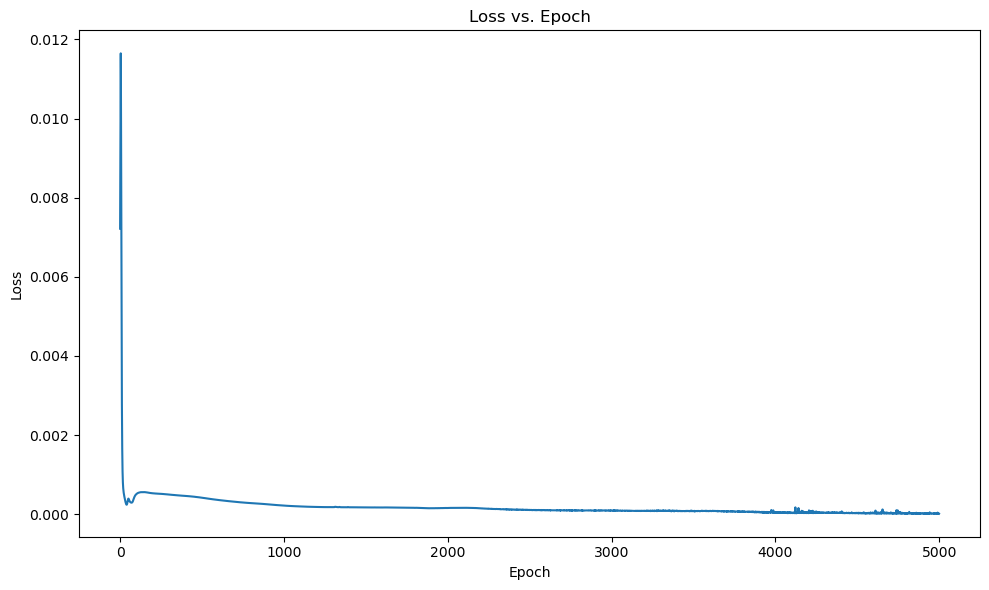

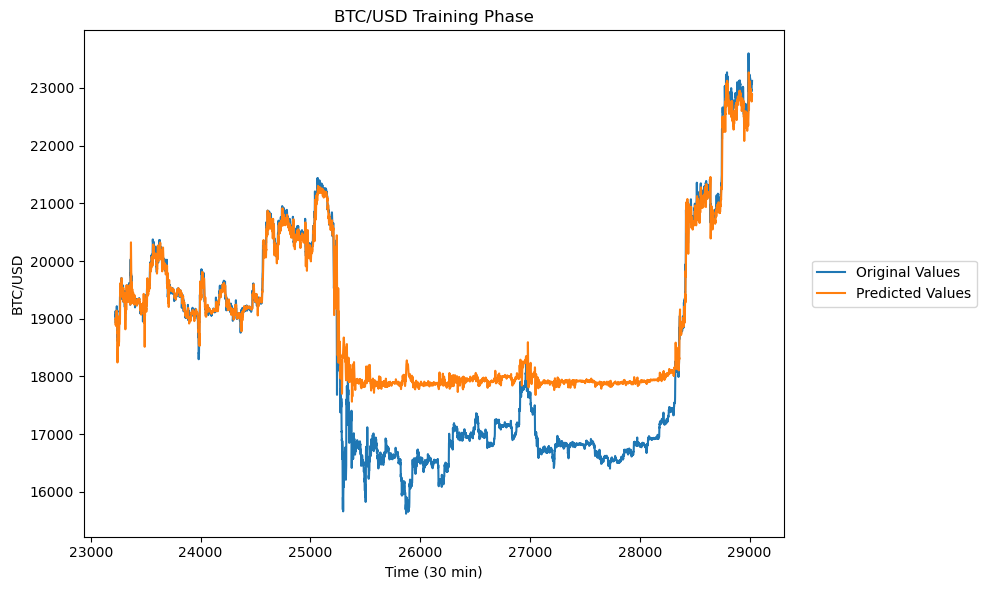

18615.0


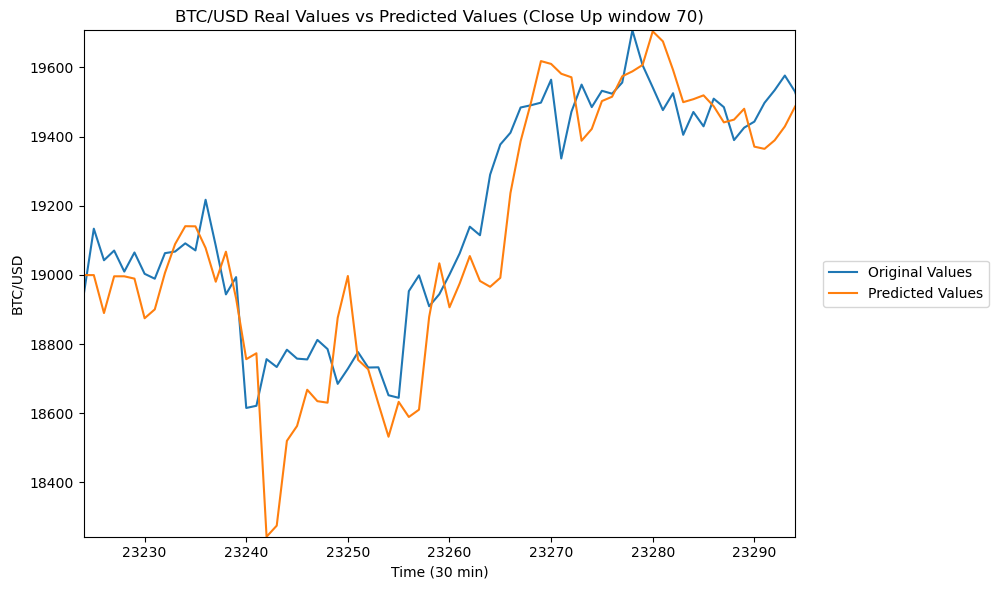

promedio -565.9434857893335


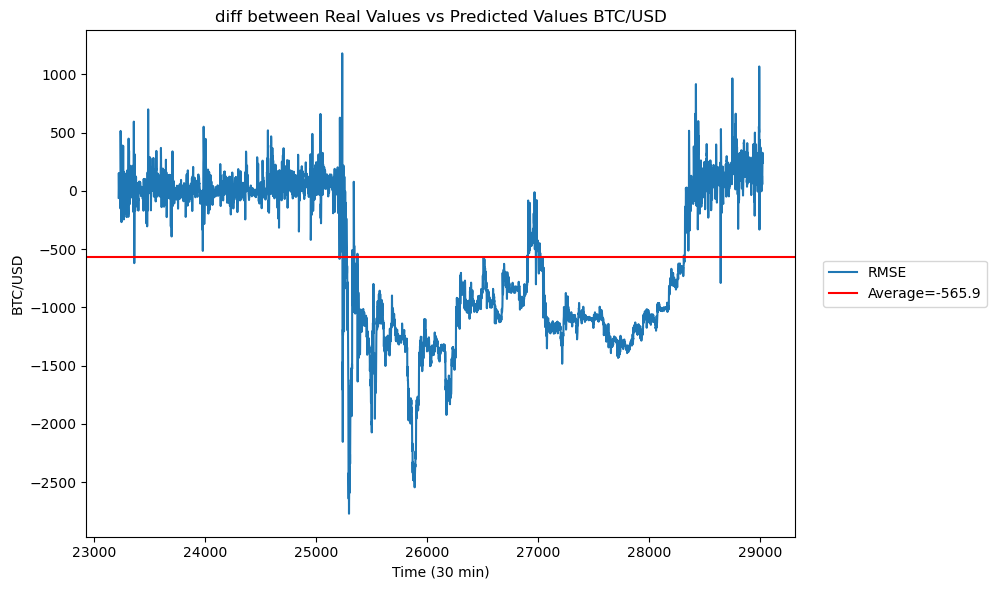

RMS 0.01615022914939131
r2 0.7927699626647201


In [152]:
# Hiperparámetros
sequence_length = 25  # Longitud de la secuencia de entrada
input_size = 5       # Tamaño de entrada (univariado)
hidden_size = 150     # Tamaño de la capa oculta LSTM
num_layers = 10       # Número de capas LSTM
output_size = 5      # Tamaño de salida (univariado)
learning_rate = 0.00001
num_epochs = 5000
params = [sequence_length,input_size,hidden_size,num_layers,output_size,learning_rate,num_epochs]
complete_run(params,train_loader,test_data,'lstm_model_30min_5')